In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve
from torchvision.models import resnet18
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
from tqdm import tqdm
import timm
import cv2
from torch.autograd import Function
import torch.nn.functional as F
from torchvision import transforms
import random
from torchvision.transforms.functional import to_pil_image
import time

In [2]:
glaucoma_img_dir = "/kaggle/input/dataset499/suspicious_glaucoma/image"
normal_img_dir = "/kaggle/input/dataset499/non_glaucoma/image"
glaucoma_label_dir = "/kaggle/input/dataset499/suspicious_glaucoma/label"
normal_label_dir = "/kaggle/input/dataset499/non_glaucoma/label"

In [3]:
def load_image_paths_labels(image_dir, label_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.txt')])
    labels = [int(open(p).read().strip()) for p in label_paths]
    return image_paths, labels

glaucoma_imgs, glaucoma_labels = load_image_paths_labels(glaucoma_img_dir, glaucoma_label_dir)
normal_imgs, normal_labels = load_image_paths_labels(normal_img_dir, normal_label_dir)
print(f"Glaucoma samples: {len(glaucoma_imgs)}, Normal samples: {len(normal_imgs)}")

Glaucoma samples: 1711, Normal samples: 3143


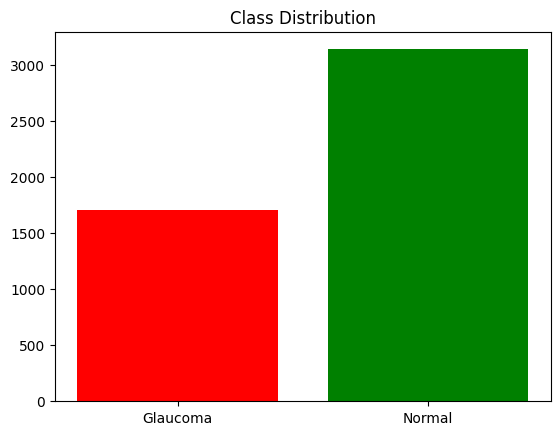

In [4]:
plt.bar(['Glaucoma', 'Normal'], [len(glaucoma_imgs), len(normal_imgs)], color=['red', 'green'])
plt.title('Class Distribution')
plt.show()

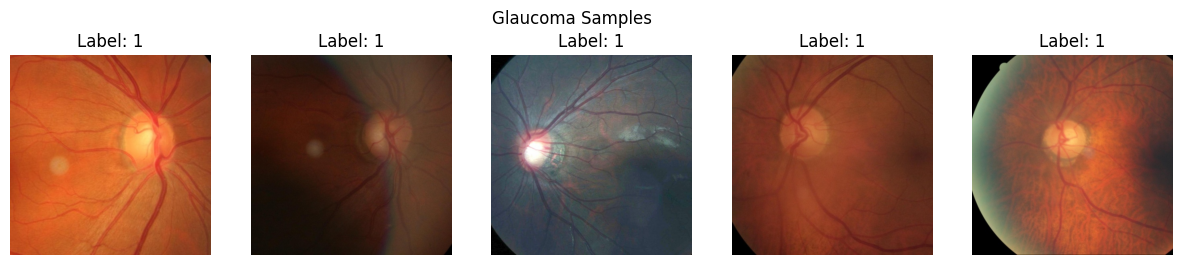

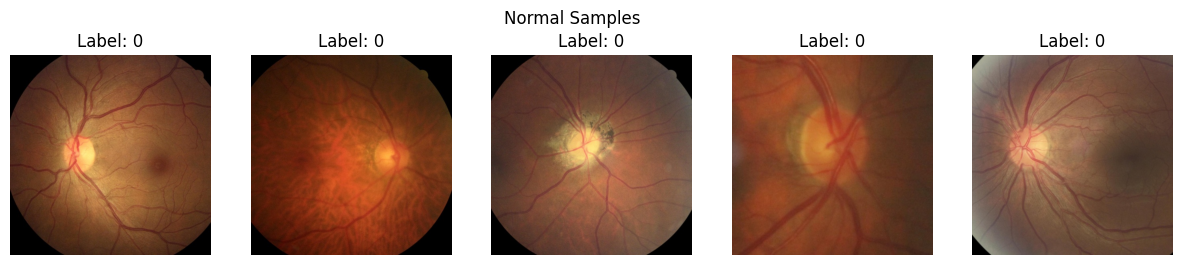

In [5]:
def show_samples(images, labels, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        img = Image.open(images[i])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Label: {labels[i]}')
    plt.suptitle(title)
    plt.show()

show_samples(glaucoma_imgs, glaucoma_labels, 'Glaucoma Samples')
show_samples(normal_imgs, normal_labels, 'Normal Samples')

In [6]:
class GlaucomaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [8]:
all_imgs = glaucoma_imgs + normal_imgs
all_labels = glaucoma_labels + normal_labels

In [9]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(all_imgs, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(test_imgs, test_labels, test_size=0.5, stratify=test_labels, random_state=42)

In [10]:
train_dataset = GlaucomaDataset(train_imgs, train_labels, transform_train)
val_dataset = GlaucomaDataset(val_imgs, val_labels, transform_val)
test_dataset = GlaucomaDataset(test_imgs, test_labels, transform_val)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [12]:
print(f"Number of training samples: {len(train_imgs)}")
print(f"Number of validation samples: {len(val_imgs)}")
print(f"Number of test samples: {len(test_imgs)}")

Number of training samples: 3883
Number of validation samples: 485
Number of test samples: 486


In [13]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda")
print("Class Weights:", class_weights)

Class Weights: tensor([0.7722, 1.4185], device='cuda:0')


In [14]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # Layer 0
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),  # Layer 3
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),  # Layer 6 (target layer)
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [15]:
def get_resnet():
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

In [16]:
def get_deit_tiny():
    model = timm.create_model('deit_tiny_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 1)  # binary classification output
    return model

In [17]:
def get_vit_tiny():
    model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 1)
    return model

In [18]:
def train_model(model, train_loader, val_loader, model_name, epochs=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss(weight=class_weights[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience = 5
    wait = 0
    start_time = time.time()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print("-" * 40)

        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            train_correct += (preds == labels.bool()).sum().item()
            train_total += labels.size(0)
            train_bar.set_postfix(loss=loss.item())

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.float().unsqueeze(1).to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.sigmoid(outputs) > 0.5
                val_correct += (preds == labels.bool()).sum().item()
                val_total += labels.size(0)
                val_bar.set_postfix(loss=loss.item())

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            wait = 0
            torch.save(model.state_dict(), f"{model_name}.pth")
            torch.save(model, f"{model_name}_full.pth")
            print("✅ Saved new best model!")
        else:
            wait += 1
            print(f"⏳ No improvement... (wait {wait}/{patience})")
            if wait >= patience:
                print("Early stopping triggered!")
                break

    total_time = time.time() - start_time
    print(f"🕒 Total training time for {model_name}: {total_time:.2f} seconds")

    model.load_state_dict(best_model_wts)
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

In [19]:
custom_model = CustomCNN()
trained_custom_model, custom_stats = train_model(custom_model, train_loader, val_loader, model_name="custom_cnn")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/50
----------------------------------------


Train Loss: 0.7284 | Val Loss: 0.5676 | Train Acc: 0.7386 | Val Acc: 0.8124 | LR: 0.000100
✅ Saved new best model!

Epoch 2/50
----------------------------------------


Train Loss: 0.5639 | Val Loss: 0.5110 | Train Acc: 0.8272 | Val Acc: 0.8227 | LR: 0.000100
✅ Saved new best model!

Epoch 3/50
----------------------------------------


Train Loss: 0.5124 | Val Loss: 0.4529 | Train Acc: 0.8362 | Val Acc: 0.8680 | LR: 0.000100
✅ Saved new best model!

Epoch 4/50
----------------------------------------


Train Loss: 0.4742 | Val Loss: 0.4188 | Train Acc: 0.8542 | Val Acc: 0.8804 | LR: 0.000100
✅ Saved new best model!

Epoch 5/50
----------------------------------------


Train Loss: 0.4393 | Val Loss: 0.3925 | Train Acc: 0.8676 | Val Acc: 0.8722 | LR: 0.000100
✅ Saved new best model!

Epoch 6/50
----------------------------------------


Train Loss: 0.4242 | Val Loss: 0.4868 | Train Acc: 0.8702 | Val Acc: 0.8557 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 7/50
----------------------------------------


Train Loss: 0.3976 | Val Loss: 0.3418 | Train Acc: 0.8836 | Val Acc: 0.9113 | LR: 0.000100
✅ Saved new best model!

Epoch 8/50
----------------------------------------


Train Loss: 0.3857 | Val Loss: 0.3336 | Train Acc: 0.8851 | Val Acc: 0.8969 | LR: 0.000100
✅ Saved new best model!

Epoch 9/50
----------------------------------------


Train Loss: 0.3624 | Val Loss: 0.3349 | Train Acc: 0.8947 | Val Acc: 0.9072 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 10/50
----------------------------------------


Train Loss: 0.3415 | Val Loss: 0.3312 | Train Acc: 0.9016 | Val Acc: 0.9175 | LR: 0.000100
✅ Saved new best model!

Epoch 11/50
----------------------------------------


Train Loss: 0.3381 | Val Loss: 0.3334 | Train Acc: 0.9032 | Val Acc: 0.9031 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 12/50
----------------------------------------


Train Loss: 0.3270 | Val Loss: 0.3086 | Train Acc: 0.8993 | Val Acc: 0.9196 | LR: 0.000100
✅ Saved new best model!

Epoch 13/50
----------------------------------------


Train Loss: 0.3086 | Val Loss: 0.3108 | Train Acc: 0.9093 | Val Acc: 0.9175 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 14/50
----------------------------------------


Train Loss: 0.3002 | Val Loss: 0.3577 | Train Acc: 0.9119 | Val Acc: 0.9093 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 15/50
----------------------------------------


Train Loss: 0.2962 | Val Loss: 0.3342 | Train Acc: 0.9148 | Val Acc: 0.9134 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 16/50
----------------------------------------


Train Loss: 0.2853 | Val Loss: 0.3093 | Train Acc: 0.9184 | Val Acc: 0.9113 | LR: 0.000030
⏳ No improvement... (wait 4/5)

Epoch 17/50
----------------------------------------


Train Loss: 0.2435 | Val Loss: 0.2844 | Train Acc: 0.9279 | Val Acc: 0.9299 | LR: 0.000030
✅ Saved new best model!

Epoch 18/50
----------------------------------------


Train Loss: 0.2358 | Val Loss: 0.2783 | Train Acc: 0.9312 | Val Acc: 0.9340 | LR: 0.000030
✅ Saved new best model!

Epoch 19/50
----------------------------------------


Train Loss: 0.2324 | Val Loss: 0.2748 | Train Acc: 0.9318 | Val Acc: 0.9340 | LR: 0.000030
✅ Saved new best model!

Epoch 20/50
----------------------------------------


Train Loss: 0.2135 | Val Loss: 0.2856 | Train Acc: 0.9403 | Val Acc: 0.9299 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 21/50
----------------------------------------


Train Loss: 0.2059 | Val Loss: 0.2844 | Train Acc: 0.9439 | Val Acc: 0.9361 | LR: 0.000030
⏳ No improvement... (wait 2/5)

Epoch 22/50
----------------------------------------


Train Loss: 0.2177 | Val Loss: 0.2841 | Train Acc: 0.9348 | Val Acc: 0.9361 | LR: 0.000030
⏳ No improvement... (wait 3/5)

Epoch 23/50
----------------------------------------


Train Loss: 0.2038 | Val Loss: 0.2780 | Train Acc: 0.9392 | Val Acc: 0.9361 | LR: 0.000009
⏳ No improvement... (wait 4/5)

Epoch 24/50
----------------------------------------


Train Loss: 0.1859 | Val Loss: 0.2728 | Train Acc: 0.9503 | Val Acc: 0.9381 | LR: 0.000009
✅ Saved new best model!

Epoch 25/50
----------------------------------------


Train Loss: 0.1890 | Val Loss: 0.2788 | Train Acc: 0.9475 | Val Acc: 0.9340 | LR: 0.000009
⏳ No improvement... (wait 1/5)

Epoch 26/50
----------------------------------------


Train Loss: 0.1828 | Val Loss: 0.2766 | Train Acc: 0.9490 | Val Acc: 0.9402 | LR: 0.000009
⏳ No improvement... (wait 2/5)

Epoch 27/50
----------------------------------------


Train Loss: 0.1841 | Val Loss: 0.2728 | Train Acc: 0.9493 | Val Acc: 0.9423 | LR: 0.000009
✅ Saved new best model!

Epoch 28/50
----------------------------------------


Train Loss: 0.1887 | Val Loss: 0.2724 | Train Acc: 0.9475 | Val Acc: 0.9402 | LR: 0.000009
✅ Saved new best model!

Epoch 29/50
----------------------------------------


Train Loss: 0.1826 | Val Loss: 0.2713 | Train Acc: 0.9480 | Val Acc: 0.9381 | LR: 0.000009
✅ Saved new best model!

Epoch 30/50
----------------------------------------


Train Loss: 0.1811 | Val Loss: 0.2680 | Train Acc: 0.9433 | Val Acc: 0.9423 | LR: 0.000009
✅ Saved new best model!

Epoch 31/50
----------------------------------------


Train Loss: 0.1826 | Val Loss: 0.2771 | Train Acc: 0.9513 | Val Acc: 0.9381 | LR: 0.000009
⏳ No improvement... (wait 1/5)

Epoch 32/50
----------------------------------------


Train Loss: 0.1780 | Val Loss: 0.2779 | Train Acc: 0.9488 | Val Acc: 0.9381 | LR: 0.000009
⏳ No improvement... (wait 2/5)

Epoch 33/50
----------------------------------------


Train Loss: 0.1901 | Val Loss: 0.2747 | Train Acc: 0.9444 | Val Acc: 0.9361 | LR: 0.000009
⏳ No improvement... (wait 3/5)

Epoch 34/50
----------------------------------------


Train Loss: 0.1835 | Val Loss: 0.2749 | Train Acc: 0.9467 | Val Acc: 0.9402 | LR: 0.000003
⏳ No improvement... (wait 4/5)

Epoch 35/50
----------------------------------------


Train Loss: 0.1746 | Val Loss: 0.2745 | Train Acc: 0.9488 | Val Acc: 0.9402 | LR: 0.000003
⏳ No improvement... (wait 5/5)
Early stopping triggered!
🕒 Total training time for custom_cnn: 1530.62 seconds


In [20]:
deit_model = get_deit_tiny()
trained_deit, deit_stats = train_model(deit_model, train_loader, val_loader, model_name="deit_tiny")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


Epoch 1/50
----------------------------------------


Train Loss: 0.4484 | Val Loss: 0.3030 | Train Acc: 0.8707 | Val Acc: 0.9031 | LR: 0.000100
✅ Saved new best model!

Epoch 2/50
----------------------------------------


Train Loss: 0.3082 | Val Loss: 0.2435 | Train Acc: 0.9130 | Val Acc: 0.9361 | LR: 0.000100
✅ Saved new best model!

Epoch 3/50
----------------------------------------


Train Loss: 0.2589 | Val Loss: 0.1730 | Train Acc: 0.9287 | Val Acc: 0.9546 | LR: 0.000100
✅ Saved new best model!

Epoch 4/50
----------------------------------------


Train Loss: 0.2289 | Val Loss: 0.2175 | Train Acc: 0.9384 | Val Acc: 0.9485 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 5/50
----------------------------------------


Train Loss: 0.1890 | Val Loss: 0.1534 | Train Acc: 0.9513 | Val Acc: 0.9567 | LR: 0.000100
✅ Saved new best model!

Epoch 6/50
----------------------------------------


Train Loss: 0.1764 | Val Loss: 0.1828 | Train Acc: 0.9521 | Val Acc: 0.9526 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 7/50
----------------------------------------


Train Loss: 0.1591 | Val Loss: 0.2722 | Train Acc: 0.9575 | Val Acc: 0.9361 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 8/50
----------------------------------------


Train Loss: 0.1685 | Val Loss: 0.1569 | Train Acc: 0.9565 | Val Acc: 0.9649 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 9/50
----------------------------------------


Train Loss: 0.1355 | Val Loss: 0.2353 | Train Acc: 0.9642 | Val Acc: 0.9505 | LR: 0.000030
⏳ No improvement... (wait 4/5)

Epoch 10/50
----------------------------------------


Train Loss: 0.0613 | Val Loss: 0.1658 | Train Acc: 0.9825 | Val Acc: 0.9649 | LR: 0.000030
⏳ No improvement... (wait 5/5)
Early stopping triggered!
🕒 Total training time for deit_tiny: 473.39 seconds


In [21]:
resnet_model = get_resnet()
trained_resnet, resnet_stats = train_model(resnet_model, train_loader, val_loader, model_name="resnet18")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]



Epoch 1/50
----------------------------------------


Train Loss: 0.4334 | Val Loss: 0.2118 | Train Acc: 0.8736 | Val Acc: 0.9443 | LR: 0.000100
✅ Saved new best model!

Epoch 2/50
----------------------------------------


Train Loss: 0.2890 | Val Loss: 0.1838 | Train Acc: 0.9251 | Val Acc: 0.9505 | LR: 0.000100
✅ Saved new best model!

Epoch 3/50
----------------------------------------


Train Loss: 0.2120 | Val Loss: 0.1208 | Train Acc: 0.9464 | Val Acc: 0.9649 | LR: 0.000100
✅ Saved new best model!

Epoch 4/50
----------------------------------------


Train Loss: 0.1570 | Val Loss: 0.2023 | Train Acc: 0.9598 | Val Acc: 0.9485 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 5/50
----------------------------------------


Train Loss: 0.1214 | Val Loss: 0.1786 | Train Acc: 0.9686 | Val Acc: 0.9608 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 6/50
----------------------------------------


Train Loss: 0.1234 | Val Loss: 0.1865 | Train Acc: 0.9683 | Val Acc: 0.9546 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 7/50
----------------------------------------


Train Loss: 0.0970 | Val Loss: 0.1087 | Train Acc: 0.9779 | Val Acc: 0.9629 | LR: 0.000100
✅ Saved new best model!

Epoch 8/50
----------------------------------------


Train Loss: 0.0894 | Val Loss: 0.1298 | Train Acc: 0.9781 | Val Acc: 0.9732 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 9/50
----------------------------------------


Train Loss: 0.0763 | Val Loss: 0.1691 | Train Acc: 0.9815 | Val Acc: 0.9670 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 10/50
----------------------------------------


Train Loss: 0.0762 | Val Loss: 0.1494 | Train Acc: 0.9825 | Val Acc: 0.9567 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 11/50
----------------------------------------


Train Loss: 0.0728 | Val Loss: 0.1308 | Train Acc: 0.9817 | Val Acc: 0.9711 | LR: 0.000030
⏳ No improvement... (wait 4/5)

Epoch 12/50
----------------------------------------


Train Loss: 0.0397 | Val Loss: 0.1014 | Train Acc: 0.9946 | Val Acc: 0.9732 | LR: 0.000030
✅ Saved new best model!

Epoch 13/50
----------------------------------------


Train Loss: 0.0153 | Val Loss: 0.1410 | Train Acc: 0.9972 | Val Acc: 0.9588 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 14/50
----------------------------------------


Train Loss: 0.0225 | Val Loss: 0.0881 | Train Acc: 0.9948 | Val Acc: 0.9773 | LR: 0.000030
✅ Saved new best model!

Epoch 15/50
----------------------------------------


Train Loss: 0.0126 | Val Loss: 0.1220 | Train Acc: 0.9982 | Val Acc: 0.9732 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 16/50
----------------------------------------


Train Loss: 0.0114 | Val Loss: 0.1126 | Train Acc: 0.9972 | Val Acc: 0.9753 | LR: 0.000030
⏳ No improvement... (wait 2/5)

Epoch 17/50
----------------------------------------


Train Loss: 0.0242 | Val Loss: 0.1088 | Train Acc: 0.9956 | Val Acc: 0.9691 | LR: 0.000030
⏳ No improvement... (wait 3/5)

Epoch 18/50
----------------------------------------


Train Loss: 0.0099 | Val Loss: 0.1265 | Train Acc: 0.9987 | Val Acc: 0.9608 | LR: 0.000009
⏳ No improvement... (wait 4/5)

Epoch 19/50
----------------------------------------


Train Loss: 0.0338 | Val Loss: 0.1115 | Train Acc: 0.9964 | Val Acc: 0.9629 | LR: 0.000009
⏳ No improvement... (wait 5/5)
Early stopping triggered!
🕒 Total training time for resnet18: 800.80 seconds


In [22]:
vit_model = get_vit_tiny()
trained_vit, vit_stats = train_model(vit_model, train_loader, val_loader, model_name="vit_tiny")

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]


Epoch 1/50
----------------------------------------


Train Loss: 0.4198 | Val Loss: 0.2577 | Train Acc: 0.8790 | Val Acc: 0.9299 | LR: 0.000100
✅ Saved new best model!

Epoch 2/50
----------------------------------------


Train Loss: 0.2554 | Val Loss: 0.1630 | Train Acc: 0.9297 | Val Acc: 0.9546 | LR: 0.000100
✅ Saved new best model!

Epoch 3/50
----------------------------------------


Train Loss: 0.1883 | Val Loss: 0.1992 | Train Acc: 0.9462 | Val Acc: 0.9402 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 4/50
----------------------------------------


Train Loss: 0.1609 | Val Loss: 0.1768 | Train Acc: 0.9572 | Val Acc: 0.9443 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 5/50
----------------------------------------


Train Loss: 0.1284 | Val Loss: 0.1589 | Train Acc: 0.9683 | Val Acc: 0.9670 | LR: 0.000100
✅ Saved new best model!

Epoch 6/50
----------------------------------------


Train Loss: 0.1123 | Val Loss: 0.1832 | Train Acc: 0.9712 | Val Acc: 0.9608 | LR: 0.000100
⏳ No improvement... (wait 1/5)

Epoch 7/50
----------------------------------------


Train Loss: 0.1158 | Val Loss: 0.1643 | Train Acc: 0.9701 | Val Acc: 0.9464 | LR: 0.000100
⏳ No improvement... (wait 2/5)

Epoch 8/50
----------------------------------------


Train Loss: 0.1139 | Val Loss: 0.1603 | Train Acc: 0.9694 | Val Acc: 0.9732 | LR: 0.000100
⏳ No improvement... (wait 3/5)

Epoch 9/50
----------------------------------------


Train Loss: 0.1245 | Val Loss: 0.1915 | Train Acc: 0.9691 | Val Acc: 0.9526 | LR: 0.000030
⏳ No improvement... (wait 4/5)

Epoch 10/50
----------------------------------------


Train Loss: 0.0777 | Val Loss: 0.1298 | Train Acc: 0.9789 | Val Acc: 0.9629 | LR: 0.000030
✅ Saved new best model!

Epoch 11/50
----------------------------------------


Train Loss: 0.0359 | Val Loss: 0.1899 | Train Acc: 0.9902 | Val Acc: 0.9567 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 12/50
----------------------------------------


Train Loss: 0.0273 | Val Loss: 0.1506 | Train Acc: 0.9936 | Val Acc: 0.9773 | LR: 0.000030
⏳ No improvement... (wait 2/5)

Epoch 13/50
----------------------------------------


Train Loss: 0.0173 | Val Loss: 0.1862 | Train Acc: 0.9954 | Val Acc: 0.9753 | LR: 0.000030
⏳ No improvement... (wait 3/5)

Epoch 14/50
----------------------------------------


Train Loss: 0.0303 | Val Loss: 0.1186 | Train Acc: 0.9936 | Val Acc: 0.9732 | LR: 0.000030
✅ Saved new best model!

Epoch 15/50
----------------------------------------


Train Loss: 0.0227 | Val Loss: 0.1905 | Train Acc: 0.9933 | Val Acc: 0.9773 | LR: 0.000030
⏳ No improvement... (wait 1/5)

Epoch 16/50
----------------------------------------


Train Loss: 0.0178 | Val Loss: 0.1623 | Train Acc: 0.9954 | Val Acc: 0.9670 | LR: 0.000030
⏳ No improvement... (wait 2/5)

Epoch 17/50
----------------------------------------


Train Loss: 0.0271 | Val Loss: 0.1536 | Train Acc: 0.9933 | Val Acc: 0.9732 | LR: 0.000030
⏳ No improvement... (wait 3/5)

Epoch 18/50
----------------------------------------


Train Loss: 0.0170 | Val Loss: 0.1707 | Train Acc: 0.9969 | Val Acc: 0.9753 | LR: 0.000009
⏳ No improvement... (wait 4/5)

Epoch 19/50
----------------------------------------


Train Loss: 0.0059 | Val Loss: 0.1726 | Train Acc: 0.9985 | Val Acc: 0.9691 | LR: 0.000009
⏳ No improvement... (wait 5/5)
Early stopping triggered!
🕒 Total training time for vit_tiny: 896.58 seconds


In [23]:
def evaluate_model(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  # Binary classification

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, auc, precision, recall, cm

In [24]:
custom_model = CustomCNN()
custom_model.load_state_dict(torch.load("custom_cnn.pth"))
resnet_model = get_resnet()
resnet_model.load_state_dict(torch.load("resnet18.pth"))
vit_model = get_vit_tiny()
vit_model.load_state_dict(torch.load("vit_tiny.pth"))

<All keys matched successfully>

In [25]:
custom_acc, custom_f1, custom_auc, custom_precision, custom_recall, custom_cm = evaluate_model(custom_model, test_loader)
resnet_acc, resnet_f1, resnet_auc, resnet_precision, resnet_recall, resnet_cm = evaluate_model(resnet_model, test_loader)
vit_acc, vit_f1, vit_auc, vit_precision, vit_recall, vit_cm = evaluate_model(vit_model, test_loader)

In [26]:
print("Custom CNN - Accuracy: {:.4f}, F1-Score: {:.4f}, ROC AUC: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(custom_acc, custom_f1, custom_auc, custom_precision, custom_recall))
print("ResNet18 - Accuracy: {:.4f}, F1-Score: {:.4f}, ROC AUC: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(resnet_acc, resnet_f1, resnet_auc, resnet_precision, resnet_recall))
print("ViT Tiny - Accuracy: {:.4f}, F1-Score: {:.4f}, ROC AUC: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(vit_acc, vit_f1, vit_auc, vit_precision, vit_recall))

Custom CNN - Accuracy: 0.9383, F1-Score: 0.9128, ROC AUC: 0.9337, Precision: 0.9075, Recall: 0.9181
ResNet18 - Accuracy: 0.9856, F1-Score: 0.9795, ROC AUC: 0.9835, Precision: 0.9824, Recall: 0.9766
ViT Tiny - Accuracy: 0.9774, F1-Score: 0.9677, ROC AUC: 0.9745, Precision: 0.9706, Recall: 0.9649


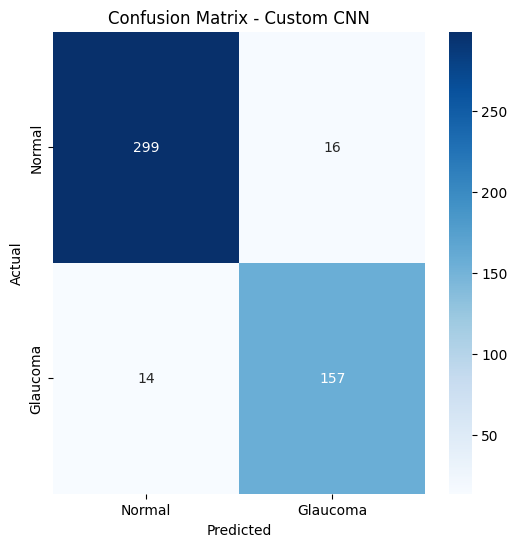

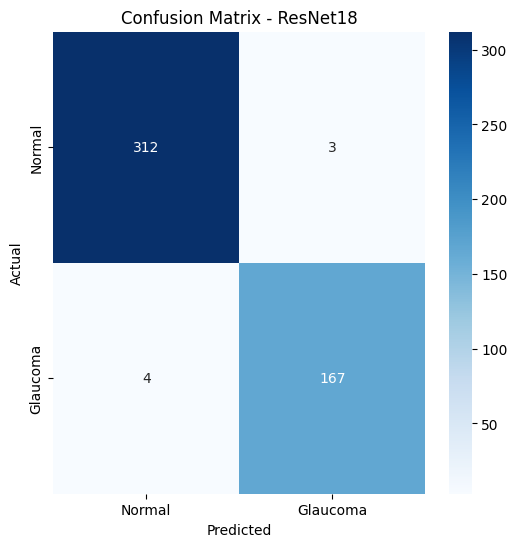

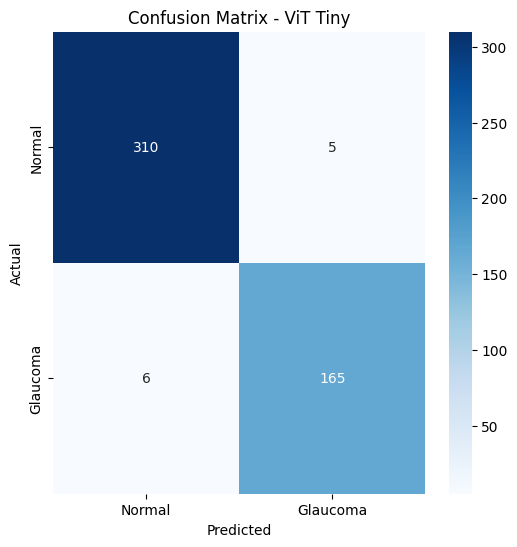

In [27]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Glaucoma"], yticklabels=["Normal", "Glaucoma"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(custom_cm, "Custom CNN")
plot_confusion_matrix(resnet_cm, "ResNet18")
plot_confusion_matrix(vit_cm, "ViT Tiny")

In [28]:
def plot_roc_curve(model, test_loader, model_name):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())  # Probability scores
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    
    # Plot ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random classifier line
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

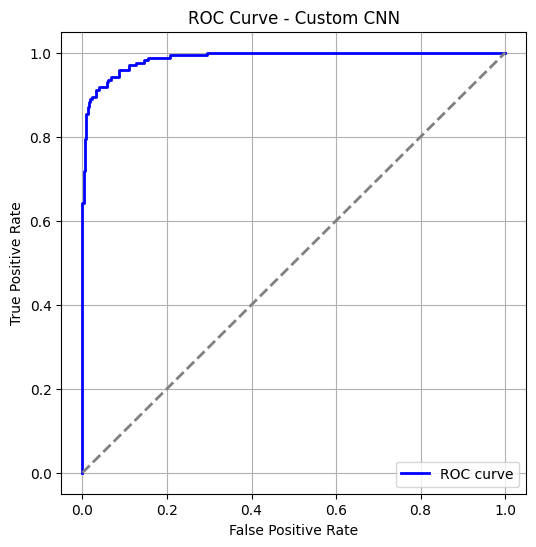

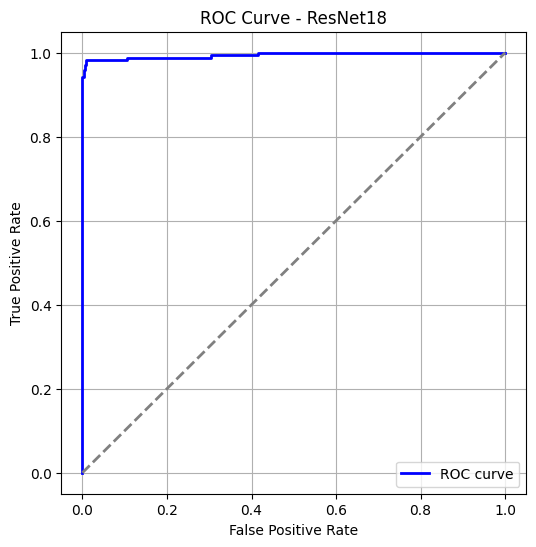

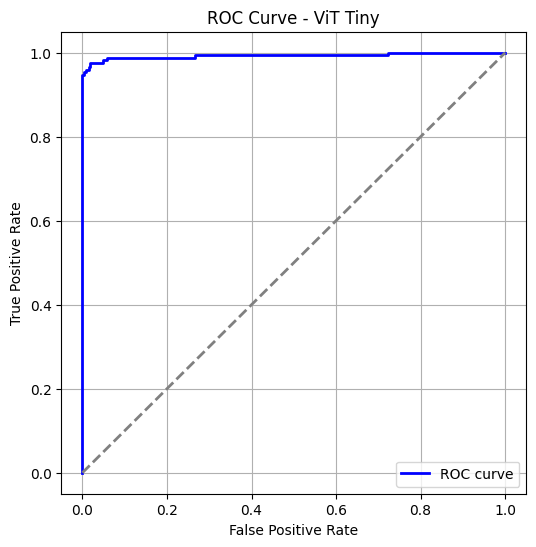

In [29]:
plot_roc_curve(custom_model, test_loader, "Custom CNN")
plot_roc_curve(resnet_model, test_loader, "ResNet18")
plot_roc_curve(vit_model, test_loader, "ViT Tiny")

In [30]:
def get_tpr_fpr(model, test_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy())  # Probability scores
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)

    return fpr, tpr

In [31]:
custom_fpr, custom_tpr = get_tpr_fpr(custom_model, test_loader)
resnet_fpr, resnet_tpr = get_tpr_fpr(resnet_model, test_loader)
vit_fpr, vit_tpr = get_tpr_fpr(vit_model, test_loader)

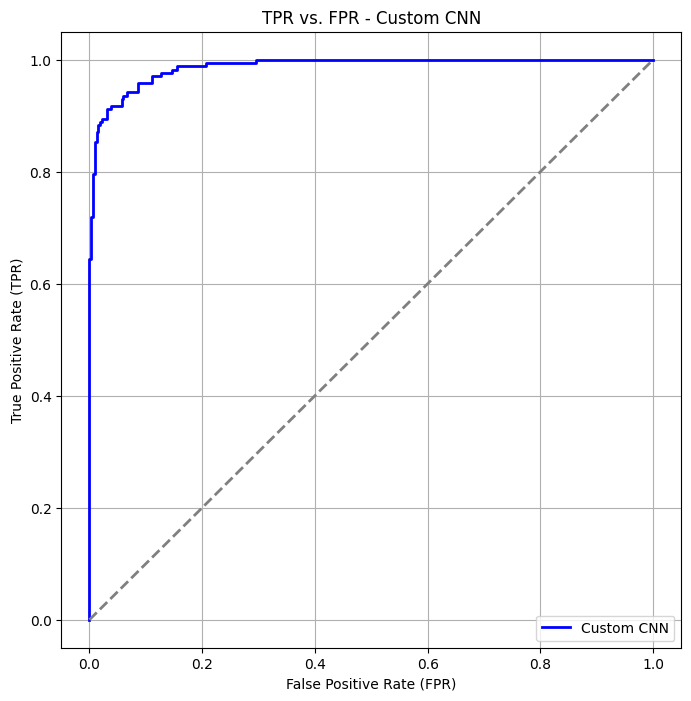

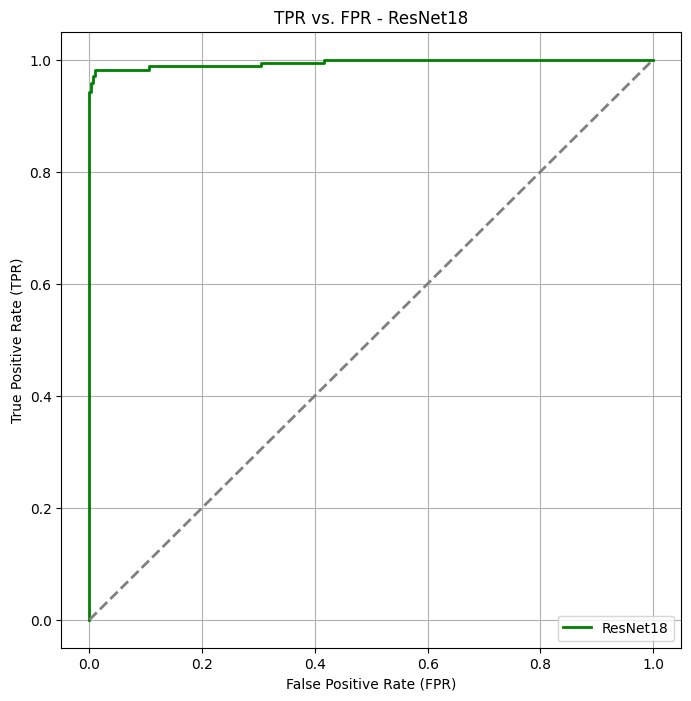

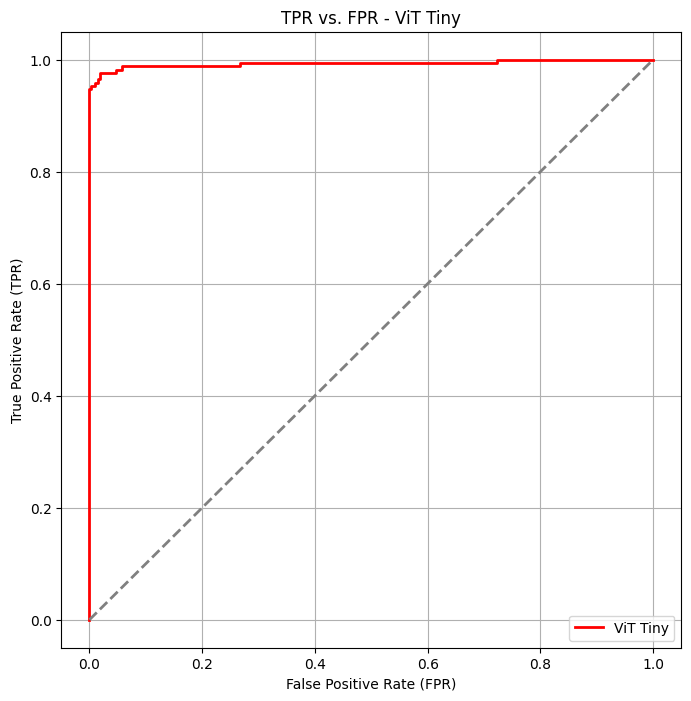

In [32]:
plt.figure(figsize=(8, 8))
plt.plot(custom_fpr, custom_tpr, color='blue', lw=2, label='Custom CNN')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random classifier line
plt.title("TPR vs. FPR - Custom CNN")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot TPR vs. FPR for ResNet18
plt.figure(figsize=(8, 8))
plt.plot(resnet_fpr, resnet_tpr, color='green', lw=2, label='ResNet18')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random classifier line
plt.title("TPR vs. FPR - ResNet18")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot TPR vs. FPR for ViT Tiny
plt.figure(figsize=(8, 8))
plt.plot(vit_fpr, vit_tpr, color='red', lw=2, label='ViT Tiny')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random classifier line
plt.title("TPR vs. FPR - ViT Tiny")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()